### PyTorch: A Tutorial To Handwritten Digit Recognition With PyTorch Using The MNIST Dataset

In [1]:
# Gives Us Access To The MNIST Dataset
from torchvision import datasets

# Transforms is a module within torchvision that contains functions to apply image transformations. These transformations are useful for data augmentation or preprocessing.
# In this case we use ToTensor which is a specific transformation that converts a PIL (Python Imaging Library) image or a NumPy ndarray into a PyTorch tensor.
from torchvision.transforms import ToTensor

In [2]:
train_data = datasets.MNIST(root = 'data', train = True, transform = ToTensor(), download = True)

test_data = datasets.MNIST(root = 'data', train = False, transform = ToTensor(), download = True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.15MB/s]


In [3]:
# Details of the Dataset
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
# Details of the Dataset
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
# The Shape. Format: Amount of images, width, height
train_data.data.shape

torch.Size([60000, 28, 28])

In [6]:
# The Shape. Format: Amount of images, width, height
test_data.data.shape

torch.Size([10000, 28, 28])

In [7]:
# How many Images
train_data.targets.size()

torch.Size([60000])

In [8]:
# Digits from 0 - 9
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [9]:
# Import the DataLoader class from PyTorch's torch.utils.data module
from torch.utils.data import DataLoader

# Define a dictionary to hold DataLoader objects for both train and test data
loaders = {

    # Define a DataLoader for the training data
    'train': DataLoader(train_data,  # The dataset to load (train_data is the training dataset)
                        batch_size=100,  # The size of each batch (100 samples per batch)
                        shuffle=True,  # Shuffle the dataset so the order is random each epoch
                        num_workers=1),  # Number of CPU cores to use for loading the data. Use 1 here.

    # Define a DataLoader for the test data (similar to train but for testing purposes)
    'test': DataLoader(train_data,  # The dataset to load (test_data should be the testing dataset)
                       batch_size=100,  # Same batch size as for training (100 samples per batch)
                       shuffle=True,  # Shuffle the test data to prevent order bias
                       num_workers=1)  # Same as for training: use 1 CPU core to load the data
}


In [10]:
# Print The DataLoaders
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7ba63d4a7550>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7ba63d4a6190>}

In [11]:
import torch.nn as nn            # Import the neural network module from PyTorch
import torch.nn.functional as F  # Import common functions like ReLU, max pooling, etc.
import torch.optim as optim      # Import optimization algorithms (e.g., SGD, Adam)

# Define the CNN class, which inherits from nn.Module (base class for all neural networks in PyTorch)
class CNN(nn.Module):

    # Initialize the layers of the network
    def __init__(self):
        super(CNN, self).__init__()

        # Define the first convolutional layer
        # This will take 1 input channel (grayscale images) and produce 10 output channels (feature maps)
        # The kernel size (filter size) is 5x5
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)

        # Define the second convolutional layer
        # This will take 10 input channels (output of the previous layer) and produce 20 output channels
        # Kernel size is also 5x5
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        # Dropout layer to prevent overfitting
        # This randomly sets some of the outputs to zero during training (with a default dropout rate of 0.5)
        self.conv2_drop = nn.Dropout()

        # Define the first fully connected (linear) layer
        # This will take 320 input features and produce 50 output features
        self.fc1 = nn.Linear(320, 50)

        # Define the second fully connected (linear) layer
        # This will take 50 input features and produce 10 output features (the number of classes for classification)
        self.fc2 = nn.Linear(50, 10)

    # Define the forward pass of the network
    def forward(self, x):

        # Apply the first convolutional layer followed by ReLU activation and 2x2 max pooling
        # Conv1: Detect basic features like edges, and max pooling reduces the spatial size (downsampling)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # Apply the second convolutional layer followed by dropout, ReLU activation, and 2x2 max pooling
        # Conv2: Detects more complex features, dropout helps prevent overfitting, and max pooling downsamples
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # Flatten the 2D feature maps from the convolutional layers into a 1D vector
        # -1 means the batch size is inferred automatically, and 320 is the total number of features
        # This is necessary to connect the convolutional layers to the fully connected layers
        x = x.view(-1, 320)

        # Pass the flattened features through the first fully connected layer followed by ReLU activation
        # The output of this layer is 50 features
        x = F.relu(self.fc1(x))

        # Apply dropout during training to prevent overfitting
        # During evaluation (testing), dropout is not applied
        x = F.dropout(x, training=self.training)

        # Pass the output through the second fully connected layer to get the final class scores (logits)
        # The output of this layer is 10 values (one for each class)
        x = self.fc2(x)

        # Apply softmax to the final output to get class probabilities
        # Softmax converts raw scores into probabilities that sum to 1
        return F.softmax(x, dim=1)  # dim=1 ensures softmax is applied across each sample's features (not across batches)

In [12]:
# Import PyTorch library for tensor operations and deep learning functionalities
import torch

# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# - If CUDA is available (i.e., a compatible GPU), the model will run on the GPU (faster computation).
# - If CUDA is not available, the code will use the CPU (which is slower for deep learning tasks).

# Initialize the CNN model and move it to the selected device (GPU or CPU)
model = CNN().to(device)
# - `CNN()` initializes the CNN model (which is defined elsewhere in the code).
# - `.to(device)` moves the model to either GPU or CPU depending on availability.

# Set up the Adam optimizer with the model's parameters and a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)
# - `model.parameters()` tells the optimizer which parameters (weights and biases) to optimize.
# - Adam is an adaptive optimizer, and it's a popular choice for training deep learning models.
# - `lr=0.001` is the learning rate, controlling the step size of each update during training.

# Define the loss function as CrossEntropyLoss, suitable for multi-class classification
loss_fn = nn.CrossEntropyLoss()
# - CrossEntropyLoss is commonly used for classification tasks where each input sample belongs to one of several classes.
# - This function calculates the difference between the predicted output and the true target values.

# Function to train the model for one epoch (one full pass through the training data)
def train(epoch):
    model.train()  # Set the model to training mode (important for layers like dropout/batchnorm)

    # Loop over the training data in batches
    for batch_idx, (data, target) in enumerate(loaders['train']):
        # Move the data and target labels to the same device as the model (either GPU or CPU)
        data, target = data.to(device), target.to(device)

        # Clear previous gradients from the optimizer (they accumulate by default)
        optimizer.zero_grad()

        # Perform a forward pass: get model predictions for the current batch of data
        output = model(data)

        # Calculate the loss (how far off the predictions are from the actual labels)
        loss = loss_fn(output, target)

        # Perform a backward pass: compute gradients of the loss with respect to model parameters
        loss.backward()

        # Update model parameters using the optimizer (based on the gradients)
        optimizer.step()

        # Every 20 batches, print the progress (helpful for monitoring training)
        if batch_idx % 20 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders['train'].dataset)} "
                  f"({100. * batch_idx / len(loaders['train']):.0f}%)]\t{loss.item():.6f}")
            # - This prints the current epoch, how many samples have been processed, and the current loss for every 20 batches.

# Function to test (evaluate) the model's performance on the test dataset
def test():
    model.eval()  # Set the model to evaluation mode (important for layers like dropout/batchnorm)

    # Initialize variables to keep track of test loss and accuracy
    test_loss = 0
    correct = 0

    # Disable gradient computation (since we're not training, this saves memory and speeds up inference)
    with torch.no_grad():
        # Loop over the test data in batches
        for data, target in loaders['test']:
            # Move the test data and target labels to the same device as the model
            data, target = data.to(device), target.to(device)

            # Get model predictions for the current batch
            output = model(data)

            # Add the loss of the current batch to the total test loss
            test_loss += loss_fn(output, target).item()

            # Get the predicted class (the class with the highest predicted score)
            pred = output.argmax(dim=1, keepdim=True)

            # Count how many predictions were correct for the current batch
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Calculate average test loss (mean over all test data)
    test_loss /= len(loaders['test'].dataset)

    # Print the test results: average loss and accuracy
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders['test'].dataset)} "
          f"({100. * correct / len(loaders['test'].dataset):.0f}%)\n")
    # - This shows the average loss over all test samples and the overall classification accuracy.

In [13]:
# Loop through the training and testing process for 10 epochs
for epoch in range(1, 11):
    # Call the 'train' function to train the model for the current epoch
    train(epoch)

    # After training the model for the current epoch, evaluate the model's performance on the test set
    test()

Train Epoch: 1 [0/60000 (0%)]	2.301117
Train Epoch: 1 [2000/60000 (3%)]	2.261086
Train Epoch: 1 [4000/60000 (7%)]	2.155995
Train Epoch: 1 [6000/60000 (10%)]	1.986563
Train Epoch: 1 [8000/60000 (13%)]	1.890035
Train Epoch: 1 [10000/60000 (17%)]	1.766249
Train Epoch: 1 [12000/60000 (20%)]	1.747553
Train Epoch: 1 [14000/60000 (23%)]	1.764811
Train Epoch: 1 [16000/60000 (27%)]	1.708770
Train Epoch: 1 [18000/60000 (30%)]	1.792212
Train Epoch: 1 [20000/60000 (33%)]	1.666129
Train Epoch: 1 [22000/60000 (37%)]	1.634328
Train Epoch: 1 [24000/60000 (40%)]	1.691413
Train Epoch: 1 [26000/60000 (43%)]	1.651315
Train Epoch: 1 [28000/60000 (47%)]	1.657513
Train Epoch: 1 [30000/60000 (50%)]	1.620328
Train Epoch: 1 [32000/60000 (53%)]	1.608250
Train Epoch: 1 [34000/60000 (57%)]	1.640387
Train Epoch: 1 [36000/60000 (60%)]	1.611785
Train Epoch: 1 [38000/60000 (63%)]	1.649751
Train Epoch: 1 [40000/60000 (67%)]	1.613431
Train Epoch: 1 [42000/60000 (70%)]	1.638209
Train Epoch: 1 [44000/60000 (73%)]	1.553444

Prediction: 7


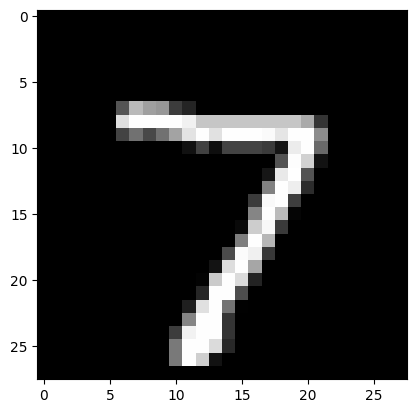

In [15]:
# Importing the necessary library for plotting images
import matplotlib.pyplot as plt

# Set the model to evaluation mode (important for layers like dropout/batchnorm to behave differently during testing)
model.eval()

# Get a sample image and its target label (true class) from the test data
data, target = test_data[0]  # Here, `test_data[0]` fetches the 1st sample (index starts at 0) Make sure to experiment and try different samples: like test_data[5] etc

# Add an extra dimension to the image tensor so that it's in the shape (1, 1, 28, 28),
# where 1 is for batch size and the second 1 is for the channel (grayscale image).
# Then, move the image to the correct device (GPU or CPU) for prediction.
data = data.unsqueeze(0).to(device)

# Pass the image through the model to get the predicted output
output = model(data)

# Get the predicted class by finding the index of the highest predicted value (this represents the class with the highest score)
# `argmax` finds the index of the maximum value in the output tensor (predicted class).
prediction = output.argmax(dim=1, keepdim=True).item()

# Print the predicted class
print(f"Prediction: {prediction}")

# Remove the extra dimensions we added earlier (to match the shape of the original image),
# and move the data back to the CPU for plotting.
# `.squeeze(0)` removes the first dimension (batch size), `.squeeze(0)` removes the second dimension (channel).
image = data.squeeze(0).squeeze(0).cpu().numpy()

# Use matplotlib to display the image, with the color map set to 'gray' for grayscale images
plt.imshow(image, cmap='gray')

# Show the image in a window
plt.show()
